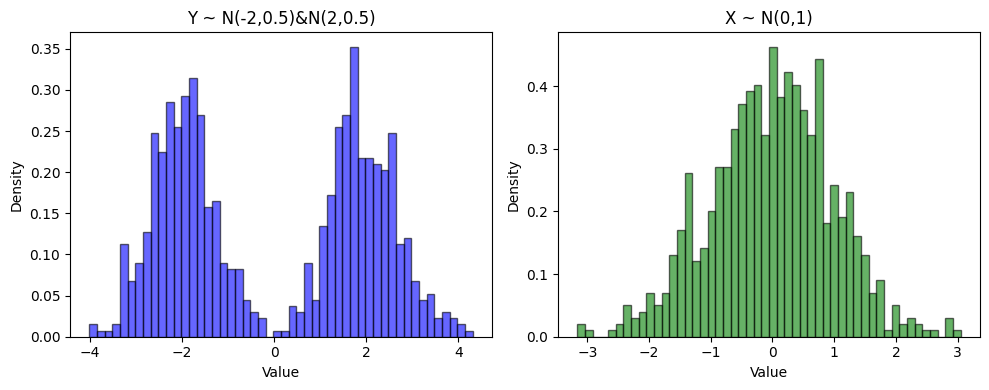

In [1]:
# Gaussian Mixture Model
# p(x) = sigma_{k=1}^{2}: pi_{k} * N(x|miu_k, sigma_k)
# pi1 = 0.5, N(x|miu=-2, sigma=0.5)
# pi2 = 0.5, N(x|miu=2, sigma=0.5)

import numpy as np
import matplotlib.pyplot as plt

# 量化到-10到10
def quantize_to_grid(x, low=-10, high=10, num_points=10000):
    grid = np.linspace(low, high, num_points)  # 在区间内均匀划分
    idx = np.abs(grid - x).argmin()            # 找到最接近的点索引
    return grid[idx]

N = 800   # sample N个数据
Y = []
X = []
for i in range(N):
    # Y ~ N(-2,0.5)&N(2,0.5)
    if np.random.uniform(0,1) < 0.5:
        x = 2 + np.random.randn(1) * (0.5**0.5)
        x = quantize_to_grid(x)
        Y.append(x)
    else:
        y = -2 + np.random.randn(1) * (0.5**0.5)
        y = quantize_to_grid(y)
        Y.append(y)

    # X ~ N(0,1)
    x = np.random.randn(1)
    x = quantize_to_grid(x)
    X.append(x)

Y = np.array(Y)
X = np.array(X)

# 绘制直方图
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(Y, bins=50, density=True, color="blue", alpha=0.6, edgecolor="black")
plt.title("Y ~ N(-2,0.5)&N(2,0.5)")
plt.xlabel("Value")
plt.ylabel("Density")

plt.subplot(1,2,2)
plt.hist(X, bins=50, density=True, color="green", alpha=0.6, edgecolor="black")
plt.title("X ~ N(0,1)")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

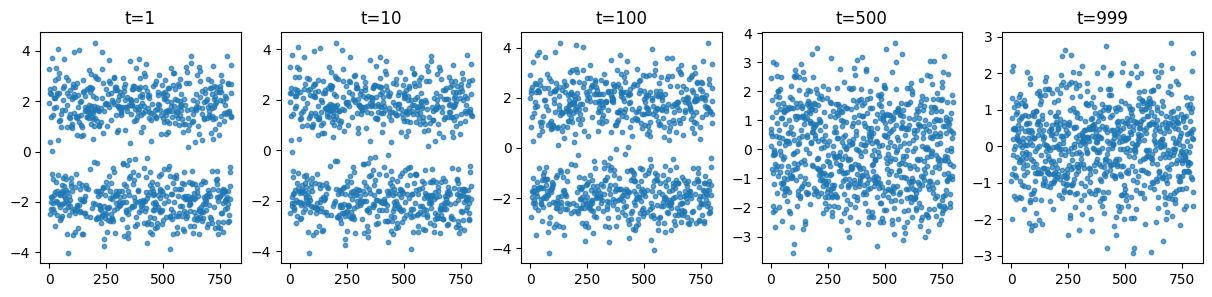

In [2]:
import torch

# 设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 前向扩散参数
T_steps = 1000  # 总步数
betas = torch.linspace(1e-4, 0.01, T_steps).to(device)  # 线性噪声调度
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # 累乘

# 加噪扩散函数
def q_sample(y0, t):
    """
    x0: [batch, 1]
    t : [batch] 时间步
    """
    noise = torch.randn_like(y0)
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).unsqueeze(-1)
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t]).unsqueeze(-1)
    return sqrt_alpha_bar * y0 + sqrt_one_minus * noise

# ==== 生成一个简单的目标数据 Y ====
Y_tensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
Y_tensor = Y_tensor.to(device)

# ==== 抽样几个时间步看看加噪结果 ====
show_steps = [1, 10, 100, 500, 999]
fig, axes = plt.subplots(1, len(show_steps), figsize=(15,3))

for i, step in enumerate(show_steps):
    t = torch.full((N,), step, dtype=torch.long)  # 所有样本同一个时间
    yt = q_sample(Y_tensor, t).cpu()  # (N,1)
    axes[i].scatter(np.arange(N), yt.squeeze().numpy(), s=10, alpha=0.7)
    axes[i].set_title(f"t={step}")

    if i == len(show_steps) - 1:
        yT = yt

plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class NoisePredictor(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + 1, hidden_dim),  # xt + x + t
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 预测噪声
        )

    def forward(self, xt, t):
        """
        xt : [batch, 1]   噪声化后的目标
        t  : [batch, 1]   时间步（直接作为数值输入）
        """
        inp = torch.cat([xt, t], dim=-1)
        return self.net(inp)


In [4]:
# === 数据准备 ===
Y_tensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(1).to(device)

dataset = torch.utils.data.TensorDataset(Y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# === 模型、优化器 ===
model = NoisePredictor(hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

T_total = T_steps  # 1000

# === 训练 ===
epochs = 800
best_loss = float("inf")
best_state = None

for epoch in range(1, epochs + 1):
    total_loss = 0
    for (y_batch,) in dataloader:   # ✅ 解包 tuple
        # 随机选择时间步
        t = torch.randint(0, T_total, (y_batch.size(0),), device=device).long()
        noise = torch.randn_like(y_batch)

        # 构造 y_t
        sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).unsqueeze(-1)
        sqrt_one_minus = torch.sqrt(1 - alpha_bars[t]).unsqueeze(-1)
        yt = sqrt_alpha_bar * y_batch + sqrt_one_minus * noise

        # t 要作为输入拼接，所以需要 [batch,1]
        t_input = t.float().unsqueeze(-1)

        # 前向
        noise_pred = model(yt, t_input)

        # loss: 预测噪声 vs 真噪声
        loss = loss_fn(noise_pred, noise)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)

    avg_loss = total_loss / len(dataloader.dataset)

    # === 记录最优模型 ===
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_state = {k: v.clone() for k, v in model.state_dict().items()}

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}]  Loss: {avg_loss:.6f} (best {best_loss:.6f})")

# === 加载最优模型 (用于反向采样) ===
if best_state is not None:
    model.load_state_dict(best_state)



Epoch [100/800]  Loss: 0.773204 (best 0.692828)
Epoch [200/800]  Loss: 0.653761 (best 0.545375)
Epoch [300/800]  Loss: 0.957431 (best 0.515528)
Epoch [400/800]  Loss: 0.587698 (best 0.515528)
Epoch [500/800]  Loss: 0.557783 (best 0.484363)
Epoch [600/800]  Loss: 0.555805 (best 0.475614)
Epoch [700/800]  Loss: 0.478068 (best 0.453344)
Epoch [800/800]  Loss: 0.564065 (best 0.445086)


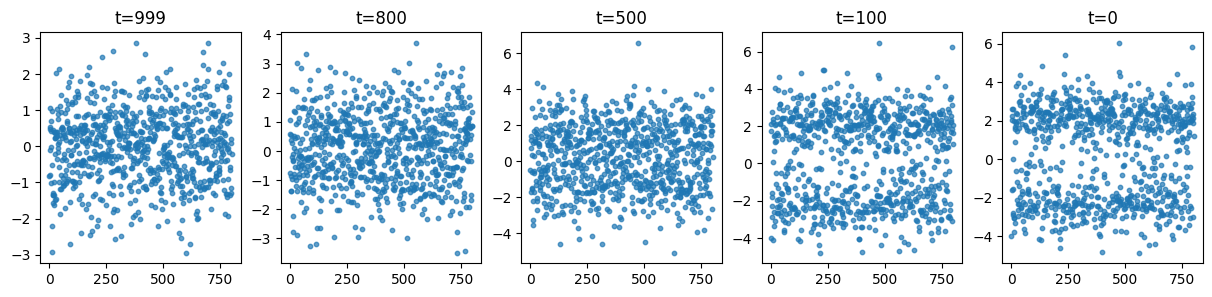

In [5]:
@torch.no_grad()
def p_sample(model, xt, t):
    """
    单步反向采样
    xt : [batch, 1]
    t  : int (当前时间步)
    """
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]

    # 模型预测噪声
    t_input = torch.full((xt.size(0), 1), t, device=device).float()
    eps_theta = model(xt, t_input)

    # 公式里的系数
    coef1 = 1.0 / torch.sqrt(alpha_t)
    coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)

    mean = coef1 * (xt - coef2 * eps_theta)

    if t > 0:
        z = torch.randn_like(xt)
        sigma = torch.sqrt(beta_t)
        return mean + sigma * z # 你可以去掉 z 这一项看看
    else:
        return mean


@torch.no_grad()
def sample(model, n_steps=T_steps, show_steps=None):
    if show_steps is None:
        show_steps = [900, 500, 300, 100, 0]
    xt = torch.randn(N, 1, device=device)  # 初始纯噪声
    # xt = yT.to(device)    # 作个弊不使用噪声作为初值
    results = {}

    for t in range(n_steps - 1, -1, -1):
        xt = p_sample(model, xt, t)
        if t in show_steps:
            results[t] = xt.detach().cpu().squeeze().numpy()

    return results


# 从 X 条件生成 Y
samples = sample(model, n_steps=T_steps, show_steps=[999, 800, 500, 100, 0])

# 可视化
fig, axes = plt.subplots(1, len(samples), figsize=(15, 3))
for i, (t, yt) in enumerate(sorted(samples.items(), reverse=True)):
    axes[i].scatter(np.arange(len(yt)), yt, s=10, alpha=0.7)
    axes[i].set_title(f"t={t}")
plt.show()
